Robel and clipping data analysis for Grazing Management and Drought Resilience (GMDR) project Thunder Basin WY

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

In [2]:
# change working directory to be project directory
os.chdir(os.path.dirname(os.getcwd()))

#Import robel and clipping data
robel= pd.read_csv('data/GMDR_ROBEL_2021.csv', parse_dates= {"RobelDate" : ["Year","Month","Date"]})
clips= pd.read_csv('data/GMDR_ExitClips.csv')

# set output directories
outDIR_clip = 'data/clip'
outDIR_vor = 'data/vor'
outDIR_vor_train = 'data/vor_train'
if not os.path.exists(os.path.join(os.getcwd(), outDIR_clip)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_clip))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor_train)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor_train))

# Robel dataframe

In [3]:
# Make a list of just the columns we want
robelcols = ['RobelDate', 'Block', 'Paddock', 'Plot', 'Direction', 'Location', 
             'Height Hi', 'Height Lo', 'Species Lo']
robel = robel[robelcols]

In [4]:
#Create robel location column that works for all years
robel['Robel_loc'] = robel['Block'].map(str) + '-' + robel['Paddock'].map(str) + '-' + robel['Location']

In [5]:
# find non-numeric values in High/Low readings
print('Low values:')
display(robel['Height Lo'].unique())
print('\n High values')
display(robel['Height Hi'].unique())

Low values:


array(['11', '7', '21', '16', '5', '4', '10', '6', '15', '8', '9', '2',
       '3', '17', '22', '12', '13', '1', '30', '14', '#VALUE!'],
      dtype=object)


 High values


array(['29', '41', '35', '52', '23', '21', '5', '31', '39', '27', '24',
       '49', '43', '36', '20', '40', '33', '17', '45', '32', '61', '38',
       '34', '16', '25', '51', '30', '9', '37', '13', '12', '11', '7',
       '26', '28', '15', '8', '10', '18', '4', '55', '22', '6', '77',
       '19', '73', '67', '65', '47', '59', '#VALUE!', '42', '3', '14',
       '2', '62', 'CHECK'], dtype=object)

In [6]:
#replace '.' with NaN and change datatpe to float
robel.loc[robel['Height Lo'] == '#VALUE!', 'Height Lo'] = np.nan
robel.loc[robel['Height Hi'] == '#VALUE!', 'Height Hi'] = np.nan
robel.loc[robel['Height Hi'] == 'CHECK', 'Height Hi'] = np.nan


robel['Height Lo'] = robel['Height Lo'].astype('float64')
robel['Height Hi'] = robel['Height Hi'].astype('float64')

In [7]:
#create year column
robel['Year']=robel['RobelDate'].dt.year

In [8]:
# create list of species to drop from VOR data
vor_spp_drop_list = ['ATCA', 'atca', 'OPPO', 'oppo', 'ARTR', 'artr', 'SD ARTR', 'ARCA', 'arca', 'SD ATCA']

In [9]:
# drop any readings input as -1
robel = robel[(robel['Height Lo'] >= 0) & (robel['Height Hi'] >= 0)]

In [10]:
# calculate percent of reading that are valid herbaceous species
vor_reading_cts = robel.groupby(['Block', 'Paddock', 'RobelDate', 'Robel_loc']).count()['Location']
robel = robel[~robel['Species Lo'].isin(vor_spp_drop_list)]
# drop any readings where low is greater than high
robel = robel[robel['Height Lo'] <= robel['Height Hi']]
vor_reading_pct = robel.groupby(['Block', 'Paddock', 'RobelDate', 'Robel_loc']).count()['Location'] / vor_reading_cts

In [11]:
# aggregate data by plot and date
robel_agg = robel.groupby(['Block', 'Paddock', 'RobelDate', 'Robel_loc']).mean().reset_index()

In [12]:
# drop any plots with < 50% valid data
robel_agg['vor_reading_pct'] = vor_reading_pct.reset_index()['Location']
robel_agg = robel_agg[robel_agg['vor_reading_pct'] > 0.50]

#### Save VOR dataset to disk

In [13]:
robel_out = robel_agg[robel_agg['Year'] == 2019].groupby(['Block', 'Paddock', 'RobelDate']).mean().reset_index().rename(
    columns={
        'Height Hi': 'High_cm',
        'Height Lo': 'Low_cm'
})

robel_out.to_csv(os.path.join(os.getcwd(), outDIR_vor, 'TB_gmdr_vor.csv'), index=False)

# Exit clips dataframe

In [14]:
# Select columns of interest to work with
clipscols=['Year', 'Date', 'Block', 'Paddock', 'Plot', 'Location', 'GrazingTrt2019', 'GrazingTrt2020', 'GrazingTrt2021', 'g/m2']
clips= clips[clipscols]

In [15]:
# Create robel location column to match the robel dataframe
clips['Robel_loc'] = clips['Block'].map(str) + '-' + clips['Paddock'].map(str) + '-' + clips['Location']


In [16]:
# Adding arbitrary late date  of 8/1 to records without a date
# NOTE: There are no longer any missing dates to assign to Aug. 1
clips['ClipDate']= clips.apply(lambda row: str(row.Year) + '-' + '8-1' if pd.isna(row.Date) else row.Date, axis=1)

# Make Date1 column a date datatype
clips['ClipDate']= pd.to_datetime(clips['ClipDate'])

In [17]:
robelclip= pd.merge_asof(clips.sort_values('ClipDate'),
                         robel_agg.sort_values('RobelDate'),
                         left_on= 'ClipDate',
                         right_on= 'RobelDate',
                         by=['Block', 'Paddock', 'Robel_loc'],
                         direction= 'nearest',
                         tolerance= datetime.timedelta(days= 22),
                         suffixes=['_clip', ''])

In [18]:
robelclipmean= robelclip.groupby(['Block', 'Paddock', 'Date']).mean().reset_index().rename(
    columns={
        'g/m2': 'Total Weight (g/m^2)',
        'Height Hi': 'High_cm',
        'Height Lo': 'Low_cm'
})

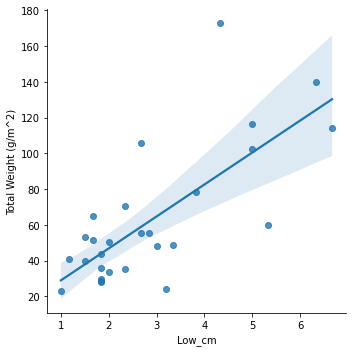

In [19]:
sns.lmplot(x='Low_cm',
y='Total Weight (g/m^2)',
data=robelclipmean)

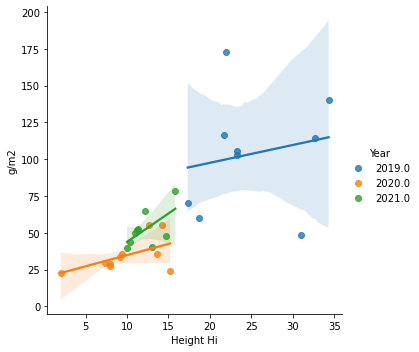

In [20]:
sns.lmplot(x='Height Hi',
           y='g/m2',
           data=robelclip.groupby(['Block', 'Paddock', 'Date']).mean().reset_index(),
           hue='Year')

In [21]:
import statsmodels.formula.api as smf
mod_both = smf.ols("Q('Total Weight (g/m^2)') ~ High_cm + Low_cm", 
                   data=robelclipmean).fit()

In [22]:
mod_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Q('Total Weight (g/m^2)')   R-squared:                       0.597
Model:                                   OLS   Adj. R-squared:                  0.565
Method:                        Least Squares   F-statistic:                     18.51
Date:                       Wed, 06 Jul 2022   Prob (F-statistic):           1.17e-05
Time:                               10:34:28   Log-Likelihood:                -128.24
No. Observations:                         28   AIC:                             262.5
Df Residuals:                             25   BIC:                             266.5
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4332     10.666      0.416      0.681     -17.534      26.400
High_cm        2.0769      1.133      1.833      0.079      -0.257       4.411
Low_cm         8.9937      5.751      1.564      0.130      -2.851      20.838
==============================================================================
Omnibus:                       15.460   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.787
Skew:                           1.085   Prob(JB):                     4.14e-06
Kurtosis:                       7.067   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
robelclipmean.to_csv(os.path.join(os.getcwd(), outDIR_vor_train, 'TB_gmdr_vor_train.csv'), index=False)